# 3η Εργασία: Βαθιά Μάθηση


Neural Networks - Team 22\
\
Alexandros Tsafos el18211\
Christina Kostaki el18136\
Sofia Vouzika el18843

## Βελτιώσεις

Στο παρόν notebook θα δούμε τις βελτιώσεις τις οποίες κάναμε στο stock μοντέλο του image captioning από το tensorflow. Τα πρώτα βήματα λήψης των δεδομένων παραμένουν ίδια:

In [6]:
!pip uninstall -y tensorflow estimator keras

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Found existing installation: keras 2.9.0
Uninstalling keras-2.9.0:
  Successfully uninstalled keras-2.9.0


In [7]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Using cached tensorflow_text-2.11.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 71.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 76.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 36.5 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstall

In [8]:
!pip install einops

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.0 MB/s eta 0:00:00


In [9]:
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request
import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

path = "/content/drive/MyDrive/Colab Notebooks/"
IMAGE_DIR = 'image_dir'
checkpoint_path = path + "checkpoints"
model_path = path + "saved_model"

In [10]:
# Download and extract the dataset zip
if not os.path.exists(path + IMAGE_DIR): # check if the data is already present
    image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                        cache_subdir=path,
                                        origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                        extract=True)
    os.remove(image_zip)

4376381805/4376381805 [==============================] - 237s 0us/step


και με το επόμενο τα "captions_new.csv", "train_files.csv" και
"test_files.csv":

In [11]:
# Download captions file
captions_file = tf.keras.utils.get_file('captions_new.csv',
                                           cache_subdir=path,
                                           origin='https://spartacus.1337.cx/flickr-mod/captions_new.csv',
                                           extract=False)

# Download train files list
train_files_list = tf.keras.utils.get_file('train_files.csv',
                                           cache_subdir=path,
                                           origin='https://spartacus.1337.cx/flickr-mod/train_files.csv',
                                           extract=False)

# Download test files list
test_files_list = tf.keras.utils.get_file('test_files.csv',
                                           cache_subdir=path,
                                           origin='https://spartacus.1337.cx/flickr-mod/test_files.csv',
                                           extract=False)

66196/66196 [==============================] - 0s 2us/step


Με τον ακόλουθο κώδικα οργανώνουμε τα filenames και τα captions σε
λίστες και ετοιμάζουμε τα train και test sets για το TensorFlow.

In [12]:
path = pathlib.Path(path)
   
captions = (path/captions_file).read_text().splitlines()
captions = (line.split('\t') for line in captions)
captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)
   
cap_dict = collections.defaultdict(list)
for fname, cap in captions:
  cap_dict[fname].append(cap)
   
train_files = (path/train_files_list).read_text().splitlines()
train_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in train_files]
   
test_files = (path/test_files_list).read_text().splitlines()
test_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in test_files]
   
train_raw = tf.data.experimental.from_list(train_captions)
test_raw = tf.data.experimental.from_list(test_captions)

Αυτή την φορά θα αναλύσουμε λίγο τις περιγραφές που έχουμε. Τυπώνουμε την κατανομή του μήκους των περιγραφών.

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


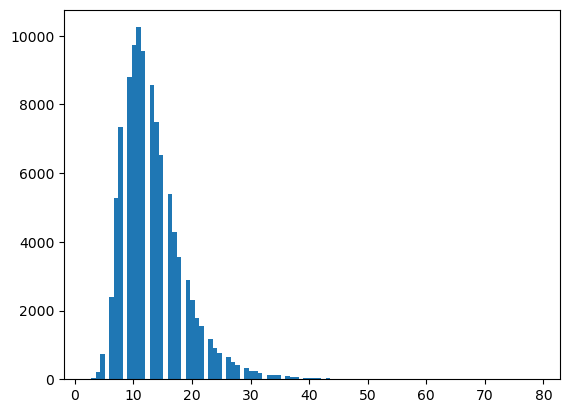

In [13]:
from matplotlib import pyplot as plt
import numpy as np
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

flat_list = [(path,item) for path, captions in train_captions for item in captions]
histogram = []

for caption in flat_list:
    count = len(word_tokenize(caption[1]))
    histogram.append(count)
    
np_histogram = np.array(histogram)
fig, ax = plt.subplots()
ax.hist(np_histogram, bins = 100)
plt.show()

Από την παραπάνω κατανομή, επιλέγουμε να κρατήσουμε περιγραφές με μήκος ανάμεσα σε 5 και 25 λέξεις.

In [14]:
MIN_LENGTH = 5
MAX_LENGTH = 25

filtered_captions = []
for (path, captions) in train_captions:
    caption_list = [caption for caption in captions 
                    if len(word_tokenize(caption)) >= MIN_LENGTH and len(word_tokenize(caption)) <= MAX_LENGTH]
    if len(caption_list) == 5:
        filtered_captions.append((path, caption_list))

In [15]:
train_raw = tf.data.experimental.from_list(filtered_captions)

train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [16]:
for ex_path, ex_captions in train_raw.take(2):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'/content/drive/MyDrive/Colab Notebooks/image_dir/_3430497.jpg', shape=(), dtype=string)
tf.Tensor(
[b'The skier is wearing a yellow jumpsuit and sliding across a yellow rail .'
 b'A yellow uniformed skier is performing a trick across a railed object .'
 b'A skier in electric green on the edge of a ramp made of metal bars .'
 b'A person on skis on a rail at night .'
 b'A skier slides along a metal rail .'], shape=(5,), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/Colab Notebooks/image_dir/_582263472.jpg', shape=(), dtype=string)
tf.Tensor(
[b'Two boys are in the foreground of a seashore scene with a boat in the background .'
 b'A couple of children playing in the shallow water with an upraised house nearby .'
 b'Two boys are playing in the water near an old building and a boat .'
 b'Two children play in the water by a pier and building .'
 b'Two children play in water in front of a building .'], shape=(5,), dtype=string)


### Εξαγωγή Χαρακτηριστικών Εικόνων

Σαν decoder θα χρησιμοοποιήσουμε το pre-trained Efficient Net, το οποίο δείχνει να έχει καλύτερες επιδόσεις από το MobileNet.

In [17]:
IMAGE_SHAPE=(224, 224, 3)
efficientnet = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMAGE_SHAPE,
)

efficientnet.trainable=False

16705208/16705208 [==============================] - 0s 0us/step


Θα προσαρμόσουμε το μέγεθος των εικόνων σε αυτό του μοντέλου με την παρακάτω συνάρτηση:

In [18]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

In [19]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(efficientnet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 1280)


In [20]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [21]:
# Use the top 7500 words for a vocabulary.
vocabulary_size = 7500
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [22]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

In [23]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'man', 'is']

In [24]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 743, 5, 2, 69, 4], [3, 2, 2518, 26, 4]]>

In [25]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [26]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [27]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

### Ετοιμασία του dataset

Τα `train_raw` και `test_raw` datasets περιέχουν 1:many `(image, captions)` ζευγάρια. 

Αυτή η συνάρτηση θα αναπαράξει την εικόνα έτσι ώστε να υπάρχουν 1:1 ζευγάρια:

In [28]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [29]:
for ex_paths, ex_captions in train_raw.repeat().batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)
 
print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)

image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


Για να είναι συμβατό με το keras, το dataset πρέπει να περιέχει ζευγάρια `(inputs, labels)`. Για την παραγωγή κειμένου τα tokens είναι ταυτόχρονα είσοδος αλλά και labels. Αυτή η συνάρτηση μετατρέπει ένα ζευγάρι `(images, texts)`  to σε ένα `((images, input_tokens), label_tokens)`:

In [30]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

Θα ακολουθήσουμε τα βήματα:

1. Φορτώνουμε όσες εικόνες μπορέσυμε.
2. Αναπαραγωγή αυτών για να ταιριάξουμε τις περιγραφές.
3. "Ανακάτεμα" των ζευγαριών `image, caption`.
4. Tokenization των κειμένων, προσθκήκη `label_tokens`.
5. Μετατροπή του κειμένου από `RaggedTensor` σε `Tensor`.

In [31]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

Μπορούμε να χρησιμοποιήσουμε τον εξαγωγές στο μοντέλο μας:

In [32]:
# Keep a third of the ds

train_ds = prepare_dataset(train_raw.shard(3, 0), tokenizer)
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [33]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

## Εκπαίδευση

### Input

Χωρίς είσοδο θέσης, ο Transformer βλέπει απλώς ένα set και όχι ένα διάνυσμα. Οπότε, σε συνδυασμό με το embedding για τα tokens, θα φριάξουμε embeddings και για τις θέσεις των διανυσμάτων.

Δημιουργούμε το επίπεδο `SeqEmbedding` που δημιουργεί embedding βάσει του έτοιμου εκπαιδευμένου μοντέλου glove-wiki-200

H χρήση του gensim δεν μας προσέφερε κάτι στις περιγραφές και το bleu score, όμως μείωσε τον χρόνο εκπαίδευσης. Προτιμάμε να μην το συμπεριλάβουμε στο τελικό μοντέλο.

In [34]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### Decoder

O decoder είναι ένας standard  Transformer-Decoder, περιέχει `DecoderLayers`, το οποία περιέχουν 3 υπο-επίπεδα: `CausalSelfAttention`, `CrossAttention`, `FeedForward`. 


In [35]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


In [36]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

In [37]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)

Το Decoder Layer θα είναι συνδυασμός των 3 παραπάνω:

In [38]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output

Υπάρχονν κάποια έξτρα βήματα που μπορούμε να κάνουμε για να το βελτιώσουμε:

1. **Handle bad tokens**: Το μοντέλο θα παράγει κείμενο. Ποτέ δεν πρέπει να παράγει pad, άγνωστο χαρακτήρα ή χαρακτήρα αρχής (`''`, `'[UNK]'`, 
   `'[START]'`). Οπότε θα πάμε το bias αυτών των tokens σε μια πολύ μεγάλη αρνητική τιμή.

2. **Smart initialization**: Η τυπική αρχικοποίση του dense layer θα δώσει ένα μοντέλο που προβλέπει όλα τα tokens με ενιαία πιθανότητα. Η βέλτιστη τιμή για το bias του κάθε token είναι ο λογάριθμος της πιθανότητάς του. Θα συμπεριλάβουμε μια μέθοδο `adapt` για να μετρήσουμε τα tokens και να υπολογίσουμε την πιθανότητα τους.

In [39]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


In [40]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

923it [00:39, 23.50it/s]


Uniform entropy: 8.92
Marginal entropy: 5.50


### "Χτίσιμο" του μοντέλου

Θα συνδυάσουμε:
1. `Feature Extractor` και `Τokenizer`
2. `GensimEmbedding`
3. `DecoderLayers`
4. `Output Layer`

In [41]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

Καλώντας το μοντέλο, δίνουμε σαν είσοδο ζευγάρια `image, txt`. Για να είναι πιο ευέλικτο στη χρήση:

* Αν η εικόνα έχει 3 κανάλια, το περνάμε από τον feature_extractor. Αλλιώς θεωρούμε πως έχει περάσει. 
* Αν το κείμενο έχει dtype `tf.string` το περνάμε από τον tokenizer.

Έπειτα, το τρέξιμο του μοντέλου είναι λίγα απλά βήματα:

1. Flattening των image features, για να περάσουν στα decoder layers.
2. Ψάχνουμε τα token embeddings.
3. Τρέχουμε το stack του `DecoderLayer`, στα features και text embeddings των εικόνων.
4. Τρέχουμε το output layer για να προβλέψουμε το επόμενο token σε κάθε θέση.


In [42]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

In [43]:
model = Captioner(tokenizer, feature_extractor=efficientnet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=3, num_heads=4)

### Beam Search

In [44]:
@Captioner.add_method
def simple_gen(self, image, beam_size=2):
    
    initial = self.word_to_index([['[START]']])                        # 'START' token == 3
    img_features = self.feature_extractor(image[tf.newaxis, ...])      # extract features from image

    tokens_list = [(initial, 0.0)]                  # list of tuples (tokens, propability): stores the top b sentences for each branch (in each iteration)
    final_tokens_list = []                          # list of tuples (tokens, propability): final top b selected sentences
    remaining_beam_size = beam_size                 # Counter for how many branches in the beam search tree have not terminated yet

    for n in range(50):

        if remaining_beam_size == 0:
            break

        new_tokens_list = []                          # top_b tokens for each branch (b*b tokens)
        for tokens, prob in tokens_list:              # tokens: [3, 15, 22, 10, ...], prob: float (ex. 0.23)
            
            if tokens[0][-1] == self.word_to_index('[END]'):
                remaining_beam_size -= 1
                final_tokens_list.append((tokens, prob))
                continue
            
            preds = self((img_features, tokens)).numpy()    # generate probabilities for all words given a sentence 'tokens' and an image 'img_features'
            preds = preds[:, -1, :]                         # get the probabilities vector only for the last word
            
            top_b_preds = tf.math.top_k(preds, k=remaining_beam_size) # get the b words with the biggest probability
            top_b_tokens = top_b_preds.indices              # tokens 
            top_b_prob = top_b_preds.values                 # probabilities
            
            for i in range(remaining_beam_size):
                next_token = [[top_b_tokens[0][i]]]           # next token to be added to the sentence (in one branch)
                new_tokens = tf.concat([tokens, next_token], axis=1)
                new_log_prob = prob + top_b_prob[0][i]
                new_tokens_list.append((new_tokens, new_log_prob))
        tokens_list = sorted(new_tokens_list, key=lambda x: -x[1])[:remaining_beam_size] # Sort the list with b*b sentences and keep the first b
    
    # Return the sentence with the biggest (probability / sentence length) score
    tokens, prob = max(final_tokens_list, key=lambda x: x[1]/len(x[0][0, 1:-1]))
    words = index_to_word(tokens[0, 1:-1])
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')

    return result.numpy().decode()

Παρακάτω, θα δούμε μια περιγραφή για μια εικόνα που θα κατεβάσουμε

In [45]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

64400/64400 [==============================] - 0s 0us/step


In [52]:
for b in (1, 2, 3):
  result = model.simple_gen(image, beam_size = b)
  print(result)

a a a a a a a a a
a a a a a a a a a
a a a a a a a a a


## Train

### Masked Loss & Accuracy

In [49]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

In [60]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for b in (1, 2, 3):
      result = self.model.simple_gen(self.image, beam_size=b)
      print(result)
    print()

In [61]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)



a a a a a a a a a
a a a a a a a a a
a a a a a a a a a



In [62]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

### Train

In [63]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [64]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=80,
    callbacks=callbacks)

Epoch 1/80


2023-02-26 09:42:26.959808: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incaptioner/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - ETA: 0s - loss: 5.2178 - masked_acc: 0.1954

a man in a man in a man
a man in a man in a man
a man in a man in a man

100/100 [==============================] - 60s 380ms/step - loss: 5.2178 - masked_acc: 0.1954 - val_loss: 5.0646 - val_masked_acc: 0.2150
Epoch 2/80
100/100 [==============================] - ETA: 0s - loss: 4.8957 - masked_acc: 0.2421

a man in a black shirt in a black
a man in a blue shirt in a black
a man in a woman

100/100 [==============================] - 24s 238ms/step - loss: 4.8957 - masked_acc: 0.2421 - val_loss: 4.7337 - val_masked_acc: 0.2458
Epoch 3/80
100/100 [==============================] - ETA: 0s - loss: 4.7006 - masked_acc: 0.2619

a man in a blue shirt is in a white shirt is in a white
a man in a blue shirt is in a white shirt is in a white
a man in a blue shirt is in a white

100/100 [==============================] - 27s 270ms/step - loss: 4.7006 - masked_acc: 0.2619 - val_loss: 4.6513 - val_masked_acc: 

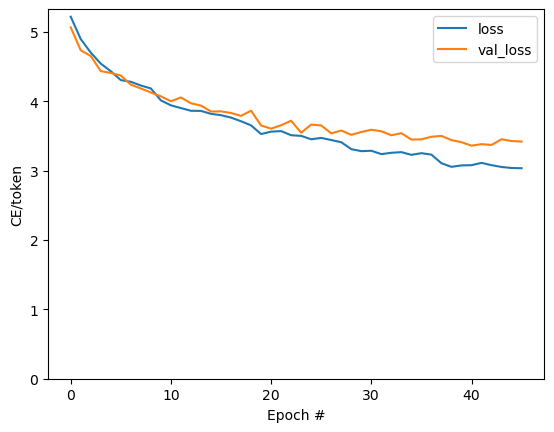

In [65]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Attention Plots

τρέχουμε το μοντέλο πάνω στην εικόνα που κατεβάσαμε

In [68]:
result = model.simple_gen(image, beam_size=3)
result

'a person in a red wetsuit is surfing on a wave'

Σπάμε το αποτέλεσμα πάλι σε tokens

In [69]:
str_tokens = result.split()
str_tokens.append('[END]')

Τα `Decoder Layers` κρατούν το attention score για το `CrossAttentionLayer`. 

In [70]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 4, 12, 49]),
 TensorShape([1, 4, 12, 49]),
 TensorShape([1, 4, 12, 49])]

In [71]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

In [72]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(12,), dtype=float32, numpy=
array([1.        , 1.        , 1.        , 1.        , 0.99999994,
       1.        , 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 1.        ], dtype=float32)>

Έτσι βλέπουμε που "πρόσεχε" το μοντέλο όταν έκανε την παραγωγή κειμένου

In [73]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

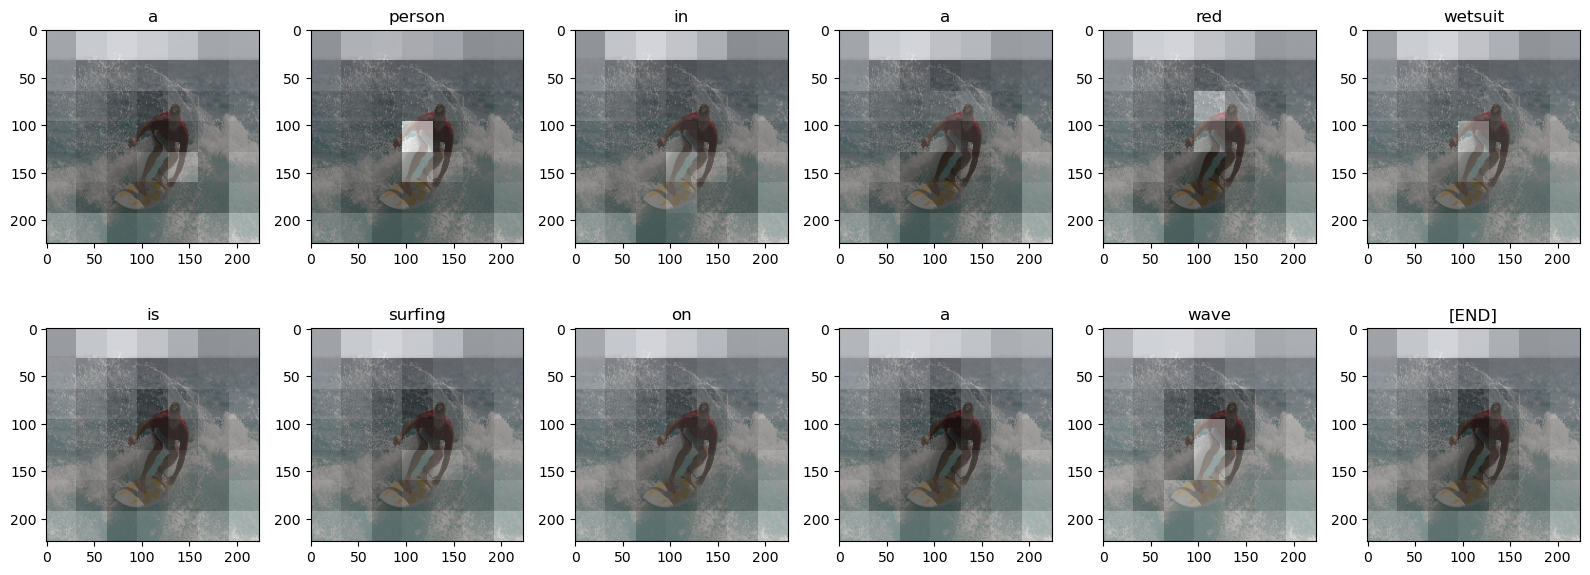

In [74]:
plot_attention_maps(image/255, str_tokens, attention_maps)

Τώρα, θα τα κάνουμε μέσω μιας συνάρτησης

In [79]:
@Captioner.add_method
def run_and_show_attention(self, image, beam_size=1):
  result_txt = self.simple_gen(image, beam_size)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)


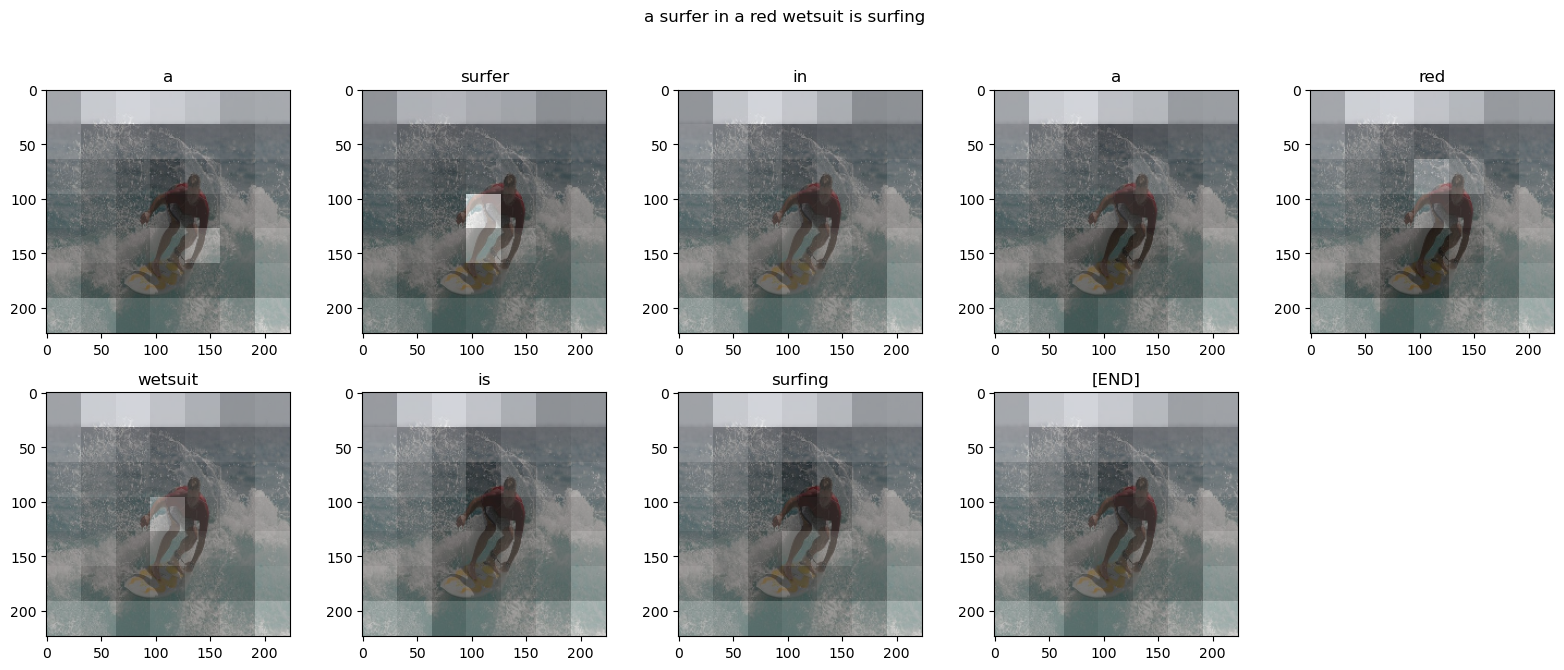

In [80]:
run_and_show_attention(model, image)

## Αξιολόγηση της ποιότητας του captioning (BLEU)

Για να παραχθεί ένα caption για μια εικόνα, πρώτα την φορτώνουμε με τη
μέθοδο `image = load_image(image_path)` και στη συνέχεια καλούμε τη
μέθοδο `model.simple_gen(image)`.

Η NLTK στο
[nltk.translate.bleu_score](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
παρέχει τις απαραίτητες συναρτήσεις για τον υπολογισμό των BLEU scores:

-   Για να μπορείτε να αξιολογούμε το captioning ενός μεμονωμένου
    παραδείγματος φτιάχνουμε μια συνάρτηση που να υπολογίζει την
    `sentence_bleu` μεταξύ hypothesis και αληθινών captions (references)
    για μια εικόνα.
-   Για να αξιολογούμε το captioning περισσότερων εικόνων πχ ενός μέρους
    ή όλου του test set φτιάχνουμε συνάρτηση που θα υπολογίζει την
    `corpus_bleu` μεταξύ όλων των hypotheses και references των εικόνων
    που του δίνονται. Σημειώστε ότι το `corpus_bleu` δεν είναι μέσος
    όρος των `sentence_bleu`.

In [81]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

weights = (0.4, 0.3, 0.2, 0.1)
smoothing_function = SmoothingFunction().method1

In [85]:
def sentence_bleu_score(index):
  path = test_captions[index][0]
  image = load_image(path)
  hypothesis = (model.simple_gen(image, beam_size=3)).split()
  sentences = test_captions[index][1]

  sentences = list(map(lambda x : (x[:-2]).split(), sentences))

  return sentence_bleu(sentences, hypothesis, weights, smoothing_function)

In [86]:
sentence_bleu_score(8)

0.029472997334359693

In [95]:
def corpus_bleu_score(indices):

  sentences_list = []
  hypotheses = []

  for index in indices:
    path = test_captions[index][0]
    image = load_image(path)
    hypotheses.append((model.simple_gen(image, beam_size=3)).split())
    sentences = test_captions[index][1:]
    sentences = list(map(lambda x : (x[:-2]).split(), sentences[0]))
    sentences_list.append(sentences)

  return corpus_bleu(sentences_list, hypotheses, weights, smoothing_function)

In [96]:
corpus_bleu_score(range(100))

0.24083264881097718

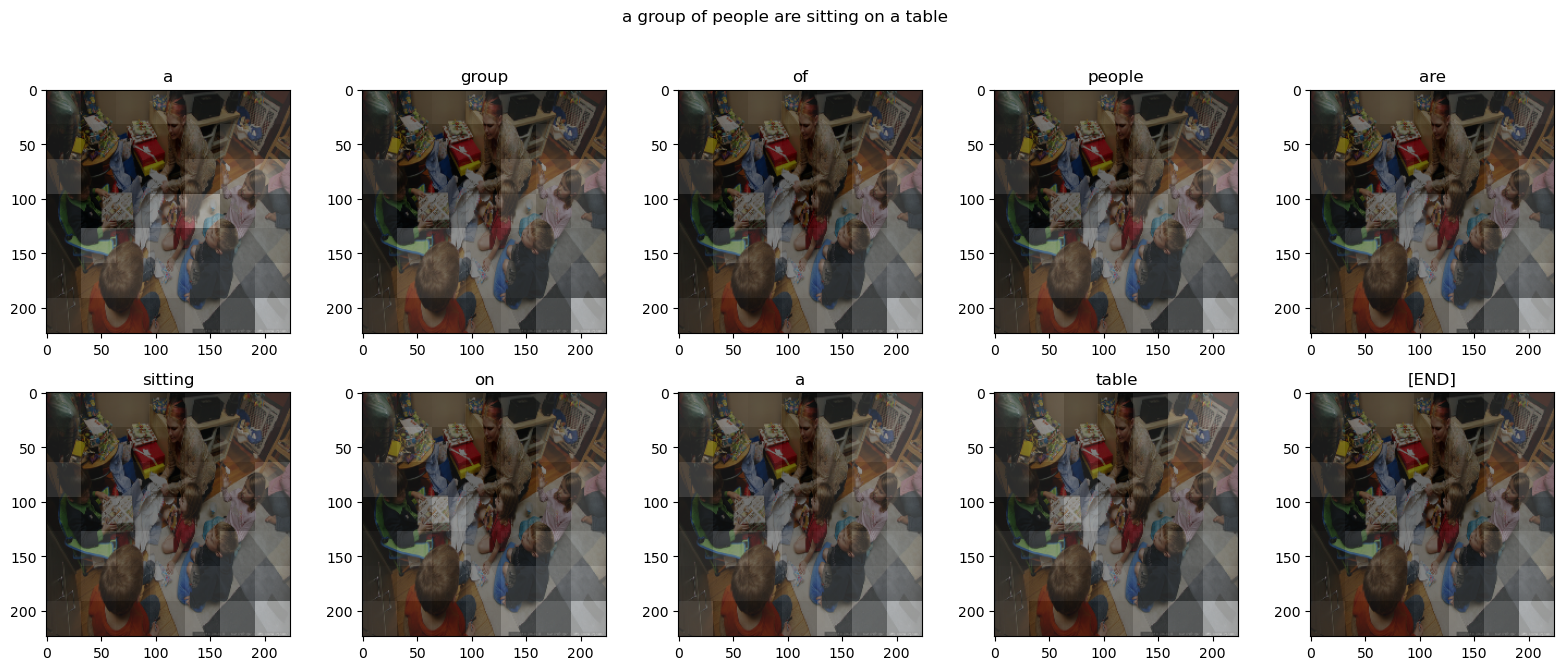

In [97]:
run_and_show_attention(model, load_image(test_captions[155][0]))

Εδώ έχουμε μια σχετικά καλή περιγραφή με εξαίρεση την τελευταία λέξη και μόνο. 

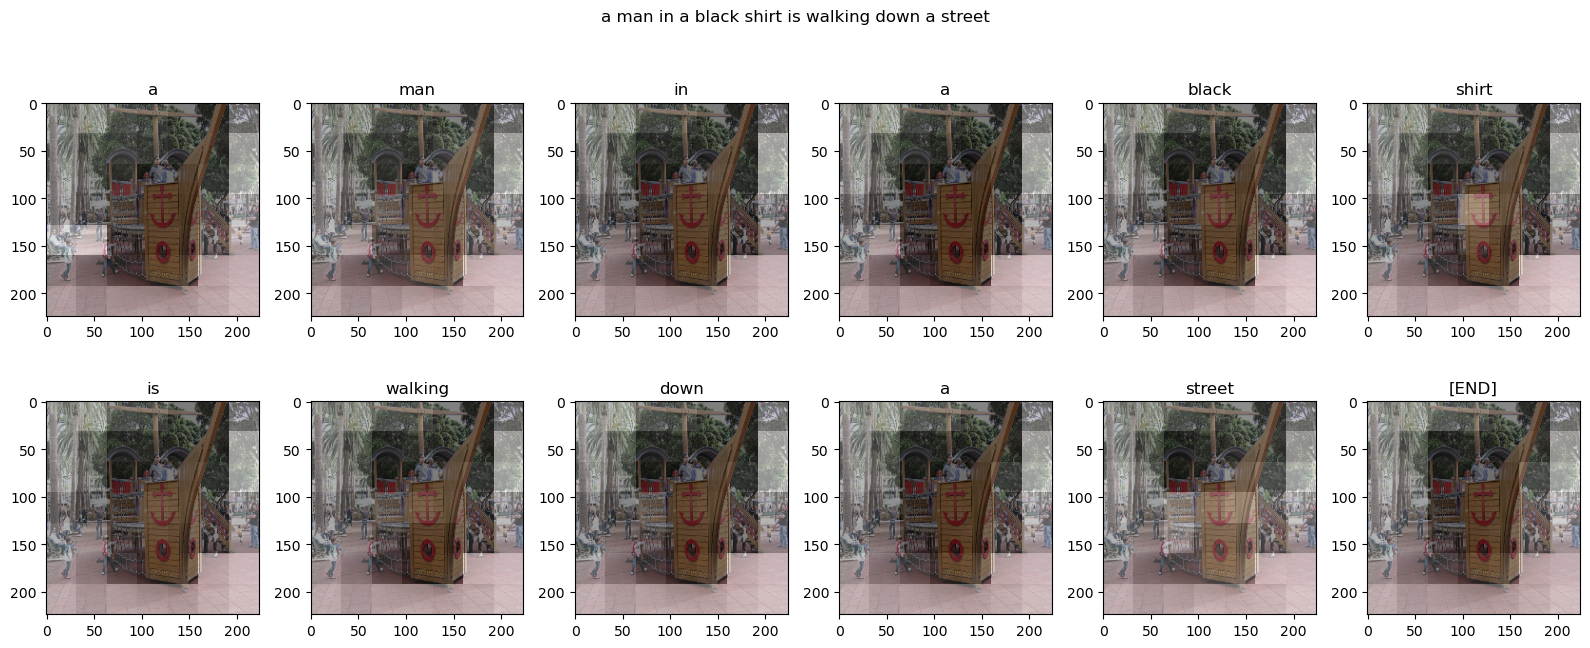

In [98]:
run_and_show_attention(model, load_image(test_captions[245][0]))

Παράδειγμα μίας εντελώς άστοχης προσπάθειας.

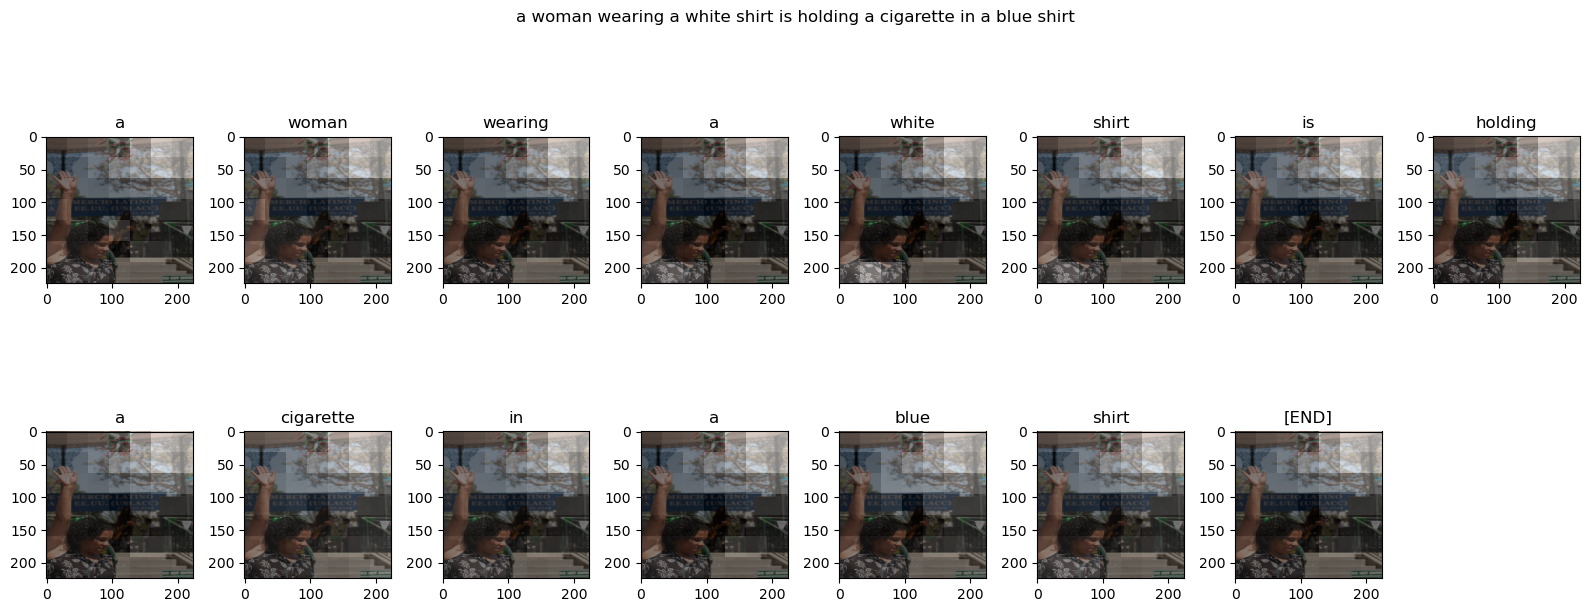

In [99]:
run_and_show_attention(model, load_image(test_captions[3][0]))

Επίσης μια άστοχη προσπάθεια. Εδώ μάλιστα η πρόταση από μόνη της δεν φαίνεται να βγάζει κάποιο νόημα.

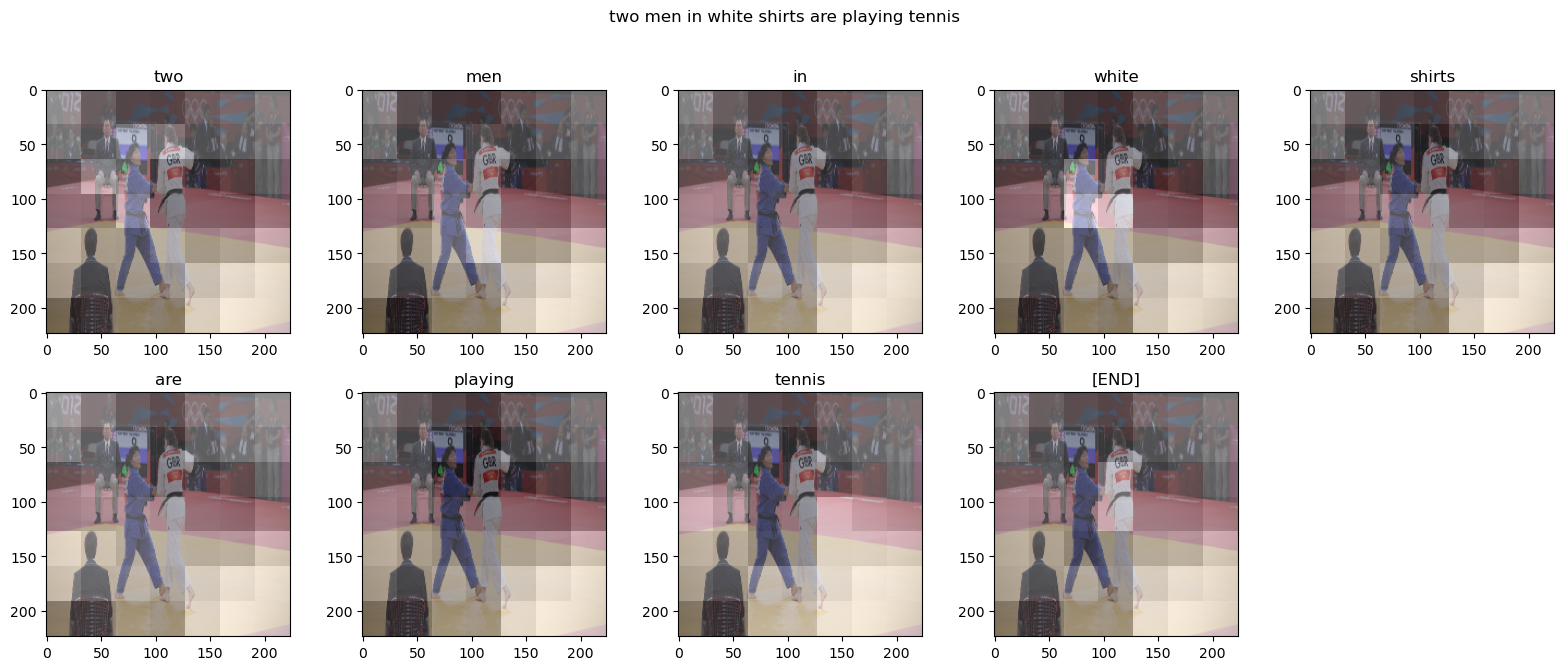

In [100]:
run_and_show_attention(model, load_image(test_captions[8][0]))

Αστοχία ως προς το άθλημα και το χρώμα της ενδυμασίας του ενός αθλητή

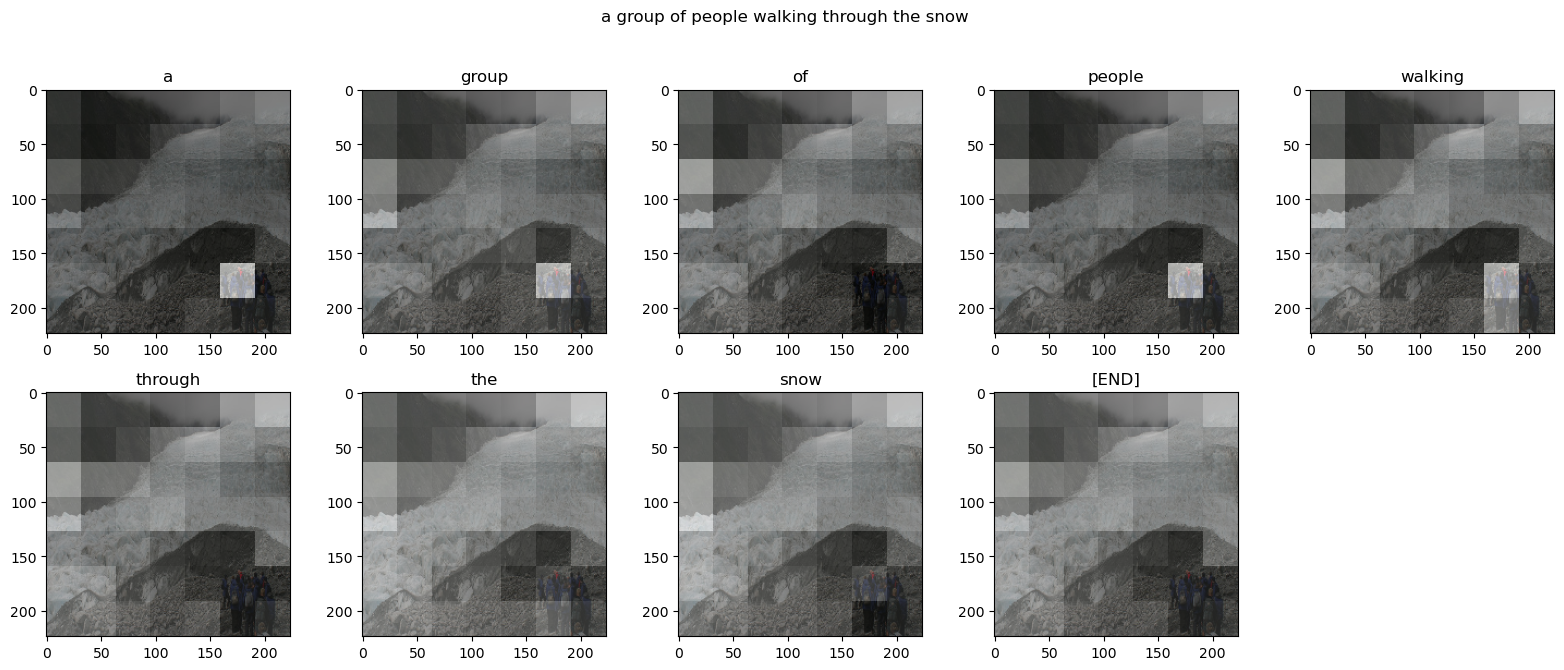

In [101]:
run_and_show_attention(model, load_image(test_captions[530][0]))

Καλή περιγραφή, με εύστοχο attention plot.